<h3 align="center">Task N1 - NN training with torch</h3>

- **Fully connected neural networks** are the foundation of deep learning models. Able to learn any function they are powerful estimators. While it's easy to build and train neural network, debugging it becomes harder and harder more complex the network becomes. Forward and backward pass might run but there could be some other mathematical error which keeps network from learning.

- To get the dataset use the code below:
```
import pandas as pd
col_names = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness',
'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome']
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv"
data = pd.read_csv(url, header=None, names=col_names)
```

- Your task is to train a binary classification network with binary cross entropy loss for predicting diabetes. Train your network with torch and with pytorch-lightning.

In [ ]:
!pip install pytorch-lightning

In [1]:
import pandas as pd
import torch
from torch import nn, optim
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from pytorch_lightning import LightningModule, Trainer

In [2]:
col_names = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
             'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome']
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv"
data = pd.read_csv(url, header=None, names=col_names)

x = data.iloc[:, :-1].values
y = data.iloc[:, -1].values

scalar = StandardScaler()
x = scalar.fit_transform(x)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [3]:
class DiabetesDataset(Dataset):
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data

    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]

    def __len__ (self):
        return len(self.X_data)

train_data = DiabetesDataset(torch.FloatTensor(x_train), torch.FloatTensor(y_train))
test_data = DiabetesDataset(torch.FloatTensor(x_test), torch.FloatTensor(y_test))

In [4]:
train_loader = DataLoader(dataset=train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=1)

In [5]:
# This is not the exact model architecture we are looking for, could be different for
# different students
class DiabetesPreidctionModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(8, 64)
        self.layer_2 = nn.Linear(64, 64)
        self.layer_out = nn.Linear(64, 1)

        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.1)
        self.batchnorm1 = nn.BatchNorm1d(64)
        self.batchnorm2 = nn.BatchNorm1d(64)

    def forward(self, inputs):
        x = self.relu(self.layer_1(inputs))
        x = self.batchnorm1(x)
        x = self.relu(self.layer_2(x))
        x = self.batchnorm2(x)
        x = self.dropout(x)
        x = self.layer_out(x)

        return x

In [6]:
model = DiabetesPreidctionModel()
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [7]:
def binary_acc(y_pred, y_test):
    y_pred_tag = torch.round(torch.sigmoid(y_pred))
    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    return acc

In [8]:
model.train()
for e in range(1, 101):
    epoch_loss = 0
    epoch_acc = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = Variable(X_batch), Variable(y_batch)
        optimizer.zero_grad()

        y_pred = model(X_batch)

        loss = criterion(y_pred, y_batch.unsqueeze(1))
        acc = binary_acc(y_pred, y_batch.unsqueeze(1))

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    if e%10 == 0: print(f'Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader):.5f} | Acc: {epoch_acc/len(train_loader):.3f}')

Epoch 010: | Loss: 0.53932 | Acc: 74.850
Epoch 020: | Loss: 0.50904 | Acc: 74.100
Epoch 030: | Loss: 0.48295 | Acc: 75.800
Epoch 040: | Loss: 0.46285 | Acc: 78.200
Epoch 050: | Loss: 0.43904 | Acc: 79.550
Epoch 060: | Loss: 0.42133 | Acc: 81.250
Epoch 070: | Loss: 0.39747 | Acc: 82.550
Epoch 080: | Loss: 0.40447 | Acc: 81.600
Epoch 090: | Loss: 0.39178 | Acc: 81.800
Epoch 100: | Loss: 0.38717 | Acc: 82.750


In [9]:
y_pred_list = []
model.eval()
with torch.no_grad():
    for X_batch, _ in test_loader:
        y_test_pred = model(X_batch)
        y_test_pred = torch.sigmoid(y_test_pred)
        y_pred_tag = torch.round(y_test_pred)
        y_pred_list.append(y_pred_tag.cpu().numpy())

y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
print(classification_report(y_test, y_pred_list, target_names=["Didn't Survive", "Survived"]))

                precision    recall  f1-score   support

Didn't Survive       0.80      0.80      0.80        99
      Survived       0.64      0.64      0.64        55

      accuracy                           0.74       154
     macro avg       0.72      0.72      0.72       154
  weighted avg       0.74      0.74      0.74       154



In [28]:
# Interpretations should go here, what they have tried and what results they got, also if student plots
# learning curves that will be great!

In [ ]:
# With pytorch lightning

In [10]:
class DiabetesModel(LightningModule):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(8, 64)
        self.layer_2 = nn.Linear(64, 64)
        self.layer_out = nn.Linear(64, 1)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.1)
        self.batchnorm1 = nn.BatchNorm1d(64)
        self.batchnorm2 = nn.BatchNorm1d(64)

    def forward(self, x):
        x = self.relu(self.layer_1(x))
        x = self.batchnorm1(x)
        x = self.relu(self.layer_2(x))
        x = self.batchnorm2(x)
        x = self.dropout(x)
        x = self.layer_out(x)
        return x

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = nn.BCEWithLogitsLoss()(y_hat, y.view(-1, 1))
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = nn.BCEWithLogitsLoss()(y_hat, y.view(-1, 1))
        y_hat = torch.sigmoid(y_hat)
        y_hat_tag = torch.round(y_hat)

        correct_sum = (y_hat_tag == y.view(-1, 1)).sum().float()
        acc = correct_sum / y.shape[0]
        acc = torch.round(acc * 100)

        self.log('val_loss', loss, prog_bar=True)
        self.log('val_acc', acc, prog_bar=True)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.0001)

In [11]:
from pytorch_lightning.callbacks import ModelCheckpoint, LearningRateMonitor

# ModelCheckpoint callback, would be a bonus point if students found this
checkpoint_callback = ModelCheckpoint(
    monitor='val_acc',
    dirpath='output/checkpoint/',
    filename='diabetes-{epoch:02d}-{val_acc:.2f}-{val_loss:.2f}',
    save_top_k=3,
    mode='max',
)

model = DiabetesModel()
trainer = Trainer(max_epochs=50, callbacks=[checkpoint_callback])
trainer.fit(model, train_loader, test_loader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:639: Checkpoint directory /content/output/checkpoint exists and is not empty.
INFO:pytorch_lightning.callbacks.model_summary:
  | Name       | Type        | Params
-------------------------------------------
0 | layer_1    | Linear      | 576   
1 | layer_2    | Linear      | 4.2 K 
2 | layer_out  | Linear      | 65    
3 | relu       | ReLU        | 0     
4 | dropout    | Dropout     | 0     
5 | batchnorm1 | BatchNorm1d | 128   
6 | batchnorm2 | BatchNorm1d | 128   
-------------------------------------------
5.1 K     Trainable params
0         Non-trainable params
5.1 K     Total p

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=1` in the `DataLoader` to improve performance.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=1` in the `DataLoader` to improve performance.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:293: The number of training batches (20) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=50` reached.


<h3 align="center">Task N2.1 - 1D Convolution operation</h3>

- **Convolution** is an operation when we have 2 functions and by merging them together we get a third function. For images, first "function" is the pixel values of the image and the second "function" is the filter itself. For 1D data(Like time-series or text) we have 1D Convolution kernels, for 2D/3D data we have appropriate kernels as well

- For time series data we can see on the below image how convolution operation is done on 1D data. It is often used for denoising the data. For example you can use an averaging kernel( 1/n, 1/n ... 1/n ) for denoising. Explain what tradeoff is between using large kernels and smaller kernels by observing the outputs.

![Image alt text](https://i.stack.imgur.com/WNIXd.png)

- Your task is to build a sliding window 1D convolution on a sine function with some noise added to it. Below you can see the code for initializing it and plotting the noisy data. Your task is to denoise the `noisy_signal` variable. Write a function which will take in the `noisy_signal` and denoise it with 1D convolution.
```
N = 1000  # Number of data points
t = np.linspace(0, 4*np.pi, N)  # Time variable
clean_signal = np.sin(t)  # Clean sin function
noise = np.random.normal(0, 0.5, N)
noisy_signal = clean_signal + noise
plt.plot(t, noisy_signal)
plt.title('Noisy Signal')
plt.show()
```

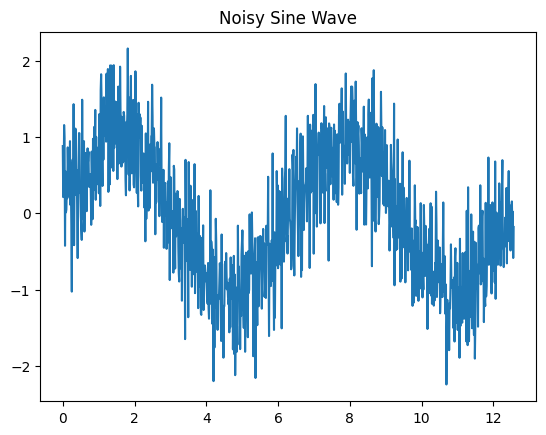

In [12]:
import numpy as np
import matplotlib.pyplot as plt

# set random seed for reproducibility
np.random.seed(0)

# Define a 1000 point long sine wave and add some noise
n = 1000
mean = 0
std = 0.5

x = np.linspace(0, 4*np.pi, n)
# Adding noise
y = np.sin(x) + np.random.normal(mean, std, n)
y_sin = np.sin(x)

# Lets plot the noisy sine wave
plt.plot(x, y)
plt.title('Noisy Sine Wave')
plt.show()

In [13]:
# Main function to grade from students
def conv1d(data, kernel_size):
    kernel = np.ones(kernel_size) / kernel_size
    pad = len(kernel) // 2
    data_padded = np.pad(data, pad, mode='edge')
    smooth_data = np.zeros_like(data)

    for i in range(pad, len(data_padded) - pad):
        smooth_data[i - pad] = np.sum(data_padded[i - pad: i + pad + 1] * kernel)

    return smooth_data

In [14]:
# Students should vary this and look at the different
# outputs, hopefully they will play around this and plot the charts
kernel_size = 3
smoothed_y = conv1d(y, kernel_size)

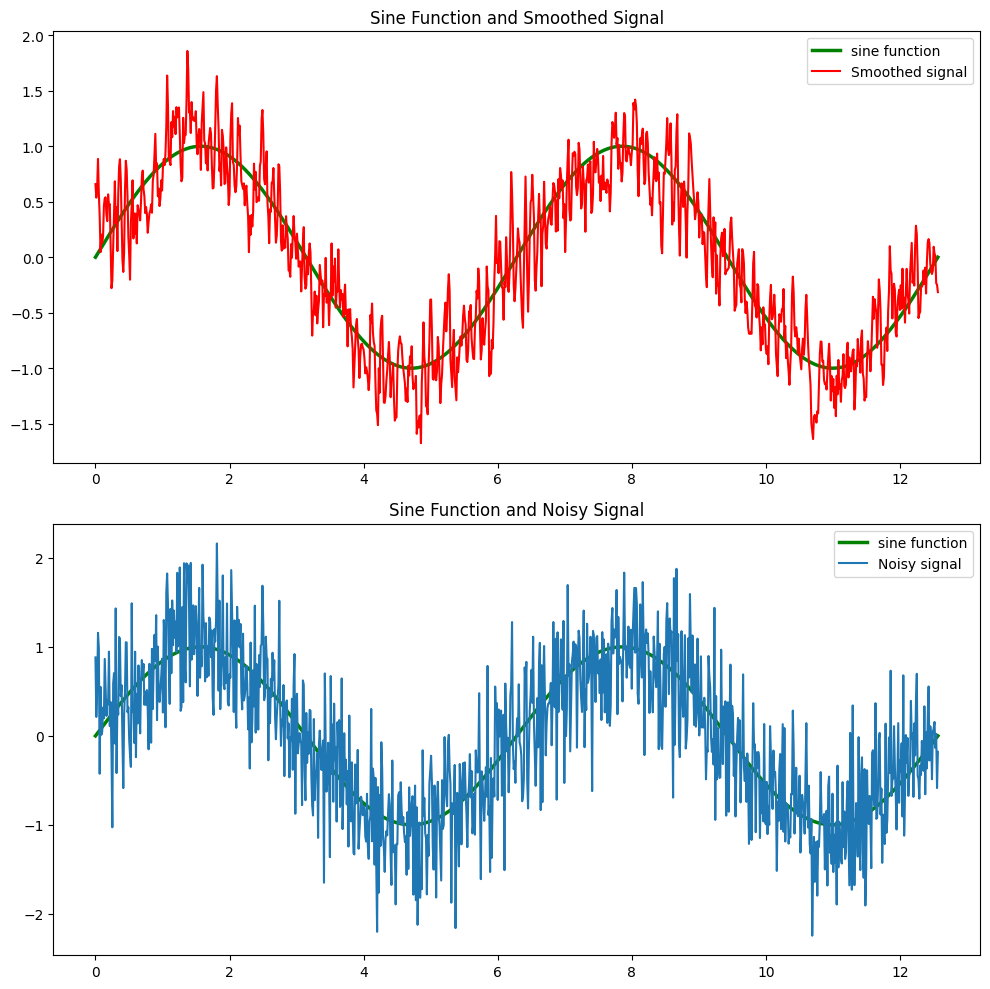

In [15]:
# Extra plots would be nice
fig, axs = plt.subplots(2, figsize=(10, 10))

axs[0].plot(x, y_sin, label="sine function", linewidth=2.5, color='green')
axs[0].plot(x, smoothed_y, 'r', label='Smoothed signal')
axs[0].legend()
axs[0].set_title('Sine Function and Smoothed Signal')

axs[1].plot(x, y_sin, label="sine function", linewidth=2.5, color='green')
axs[1].plot(x, y, label='Noisy signal')
axs[1].legend()
axs[1].set_title('Sine Function and Noisy Signal')

plt.tight_layout()
plt.show()


<h3 align="center">Task N2.2 - 2D Convolution operation</h3>

- In image processing **Convolution** filter/kernel is a $k \times k$ matrix which is used for retrieving useful features from the image. It is a fundamental building block of Convolutional neural networks(CNN)

- After applying the kernel over the image, we often get a downsampled feature map from the image as shown in the animation below:
  
<center><img src="https://drive.google.com/uc?export=view&id=153Aj-MSmLndc3dNhl9HvbpNZhDGlYB_I" alt="Example" /></center>


- Your job is to write a convolution operation as a function(without using packages like torch,tensorflow, keras etc.) which takes in image of shape (**CxHxW**, C - Channel(usually RGB), H - Height of the image, W - Width of the image) and get the output image after applying convolution like it's shown in the illustration.

- For testing the output you can use the **uniform blur** kernel for any image you like which is defined below:
  \begin{equation}
K = \frac{1}{9} \begin{bmatrix}
1 & 1 & 1 \\
1 & 1 & 1 \\
1 & 1 & 1
\end{bmatrix}
\end{equation}

- Try your function on grayscale images with Sobel Operator and explain the output:
\begin{equation}
K = \begin{bmatrix}
-1 & 0 &  1 \\
-2 & 0 & 2 \\
-1 & 0 & 1
\end{bmatrix}
\end{equation}

In [16]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

def conv2d(image: np.array, kernel:np.array, pad: bool, pad_size: int = 0):

    if len(image.shape) == 2:
        image_height, image_width = image.shape
        num_channels = 1
        image = np.expand_dims(image, -1) # Adding channel dimension for grayscale image
    else:
        image_height, image_width, num_channels = image.shape

    kernel_height, kernel_width = kernel.shape

    if pad:
        padded_image = np.pad(image, ((pad_size,pad_size),
                                      (pad_size,pad_size),
                                      (0,0)), mode='constant')
        output_height = image_height + 2*pad_size - kernel_height + 1
        output_width = image_width + 2*pad_size - kernel_width + 1
    else:
        padded_image = image
        output_height = image_height - kernel_height + 1
        output_width = image_width - kernel_width + 1

    output = np.zeros((output_height, output_width, num_channels))

    kernel = np.expand_dims(kernel, -1)
    kernel = np.repeat(kernel, num_channels, axis=-1) # Ensure kernel shape matches image

    for i in range(output_height):
        for j in range(output_width):
            output[i, j] = (padded_image[i:i+kernel_height, j:j+kernel_width] * kernel).sum(0).sum(0)

    if num_channels == 1:
        output = np.squeeze(output, -1) # Remove channel axis for grayscale image

    return output

In [21]:
# Student should show that function works for both RGB and grayscale images
# or if student only shows output on RGB image, then later we will see
# if that function works on grayscale images on the 2nd part of this task(sobel operator)
# Showing different blur intensities is not needed but is a plus if student explores this area.
blur_intensity_3 = 3
blur_intensity_9 = 9
blur_kernel_3 = np.array([[1/(blur_intensity_3**2) for _ in range(blur_intensity_3)] for _ in range(blur_intensity_3)])
blur_kernel_9 = np.array([[1/(blur_intensity_9**2) for _ in range(blur_intensity_9)] for _ in range(blur_intensity_9)])
img_gray = Image.open("some_image.jpg").convert("L")
img_rgb = Image.open("some_image.jpg").convert("RGB")
img_gray = np.array(img_gray)
img_rgb = np.array(img_rgb)

img_conv_gray = conv2d(img_gray, blur_kernel_3, True, 1)
img_conv_rgb = conv2d(img_rgb, blur_kernel_9, True, 1)
img_conv_rgb = img_conv_rgb.astype(np.uint8)
img_conv_gray = img_conv_gray.astype(np.uint8)

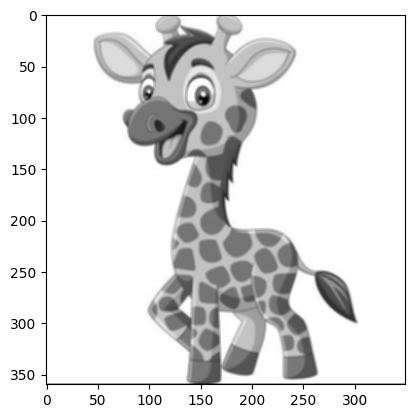

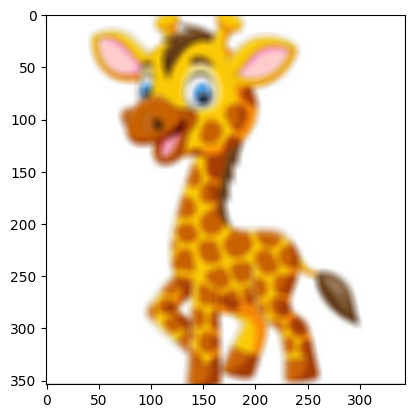

In [22]:
# Display the convolved images
plt.imshow(img_conv_gray, cmap="gray")
plt.show()

plt.imshow(img_conv_rgb)
plt.show()

In [23]:
# Initialize array with Sobel Operator(x, y)
sobel_y = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]])
sobel_x = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])

img = np.array(Image.open("some_image.jpg").convert("L"))
img_edges_x = conv2d(img, sobel_x, True, 1)
img_edges_y = conv2d(img, sobel_y, True, 1)

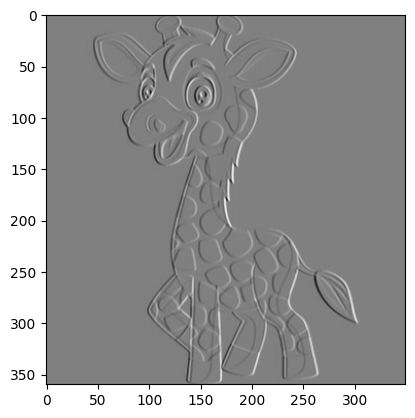

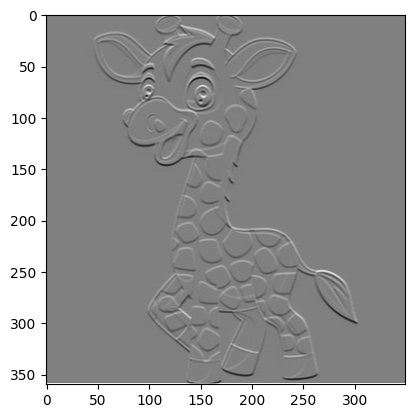

In [24]:
img_edges_y.astype(np.uint8)
plt.imshow(img_edges_x, cmap="gray")
plt.show()

img_edges_x.astype(np.uint8)
plt.imshow(img_edges_y, cmap="gray")
plt.show()